In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sqlite3 as sql

from scripts.create_charts import *

connection = sql.connect('data/taylor_swift.db')

In [2]:
eras = {
    'Taylor Swift': '#A5C9A5',
    'Fearless (TV)': '#EFC180',
    'Speak Now (TV)': '#C7A8CB',
    'Red (TV)': '#7A2E39',
    '1989 (TV)': '#B5E5F8',
    'reputation': '#746F70',
    'Lover': '#F7B0CC',
    'folklore': '#CDC9C1',
    'evermore': '#C5AC90',
    'Midnights': '#242E47'
}

In [3]:
credits_query_blank = '''
WITH {0}Count AS (
    SELECT 
        a.album_era AS era,
        {3}.song_{1} AS {1},
        COUNT(*) AS {1}_count_per_era,
        SUM(COUNT(*)) OVER (PARTITION BY {3}.song_{1}) AS total_songs_{1},
        SUM(COUNT(*)) OVER (PARTITION BY a.album_era) AS total_{1}_credits
    FROM 
        albums a
        LEFT JOIN songs s ON a.album_title = s.album_title
        LEFT JOIN {2} {3} ON s.song_title = {3}.song_title
    GROUP BY
        a.album_era, {3}.song_{1}
),
{0}Aggregated AS (
    SELECT
        era,
        CASE
            WHEN total_songs_{1} = 1 THEN 'One-Time {0}s'
            ELSE {1}
        END AS {1},
        SUM({1}_count_per_era) AS song_count,
        total_songs_{1},
        SUM(total_{1}_credits) AS total_{1}_credits
    FROM
        {0}Count
    GROUP BY
        era, {1}
)
SELECT
    era,
    {1},
    SUM(song_count) AS song_count,
    SUM(total_songs_{1}) AS total_songs_{1},
    total_{1}_credits
FROM
    {0}Aggregated
WHERE
    {1} != 'Taylor Swift'
GROUP BY
    era, {1}
'''

In [4]:
writers_query = credits_query_blank.format('Writer', 'writer', 'writers', 'w')

writers = pd.read_sql(writers_query, connection)

# Set writer order to have 'One-Time Writers' appear last
custom_categories = sorted(set(writers['writer']) - {'One-Time Writers'}) + ['One-Time Writers']
writers['writer'] = pd.Categorical(writers['writer'], categories=custom_categories, ordered=True)

# Set era order to be chronological
writers['era'] = pd.Categorical(writers['era'], eras.keys())
writers.sort_values('era', inplace=True)
writers.head(10)

,era,writer,song_count,total_songs_writer,total_writer_credits
36,Taylor Swift,Robert Ellis Orrall,3,4,35
35,Taylor Swift,One-Time Writers,4,4,35
34,Taylor Swift,Liz Rose,8,17,35
33,Taylor Swift,Angelo Petraglia,2,2,35
10,Fearless (TV),Liz Rose,8,17,44
11,Fearless (TV),One-Time Writers,8,8,44
12,Fearless (TV),Tommy Lee James,2,2,44
28,Red (TV),Ed Sheeran,2,3,50
32,Red (TV),Shellback,4,21,50
31,Red (TV),One-Time Writers,8,8,50


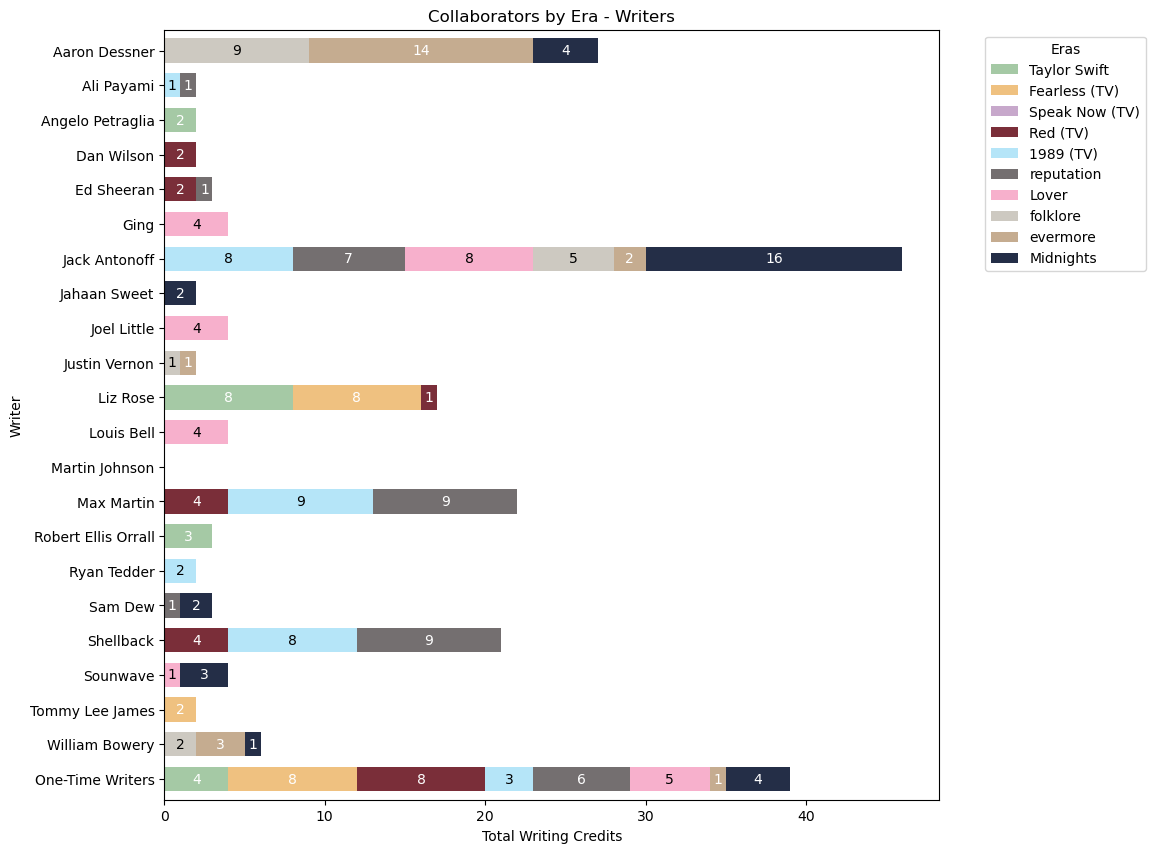

In [5]:
writers_chart = stacked_bar_chart('barh', writers, 'writer', 'song_count', 'era', eras, 'Collaborators by Era - Writers', 'Total Writing Credits', 'Writer', 'Eras')

In [6]:
producers_query = credits_query_blank.format('Producer', 'producer', 'producers', 'p')

producers = pd.read_sql(producers_query, connection)

# Set producer order to have 'One-Time Writers' appear last
custom_categories = sorted(set(producers['producer']) - {'One-Time Producers'}) + ['One-Time Producers']
producers['producer'] = pd.Categorical(producers['producer'], categories=custom_categories, ordered=True)

# Set era order to be chronological
producers['era'] = pd.Categorical(producers['era'], eras.keys())
producers.sort_values('era', inplace=True)
producers.head(10)

,era,producer,song_count,total_songs_producer,total_producer_credits
39,Taylor Swift,Robert Ellis Orrall,5,5,20
38,Taylor Swift,One-Time Producers,3,3,20
37,Taylor Swift,Nathan Chapman,12,13,20
12,Fearless (TV),ELVIRA,1,3,51
10,Fearless (TV),Aaron Dessner,2,41,51
11,Fearless (TV),Christopher Rowe,19,61,51
13,Fearless (TV),Jack Antonoff,4,63,51
36,Speak Now (TV),Jack Antonoff,3,63,44
35,Speak Now (TV),Christopher Rowe,16,61,44
34,Speak Now (TV),Aaron Dessner,3,41,44


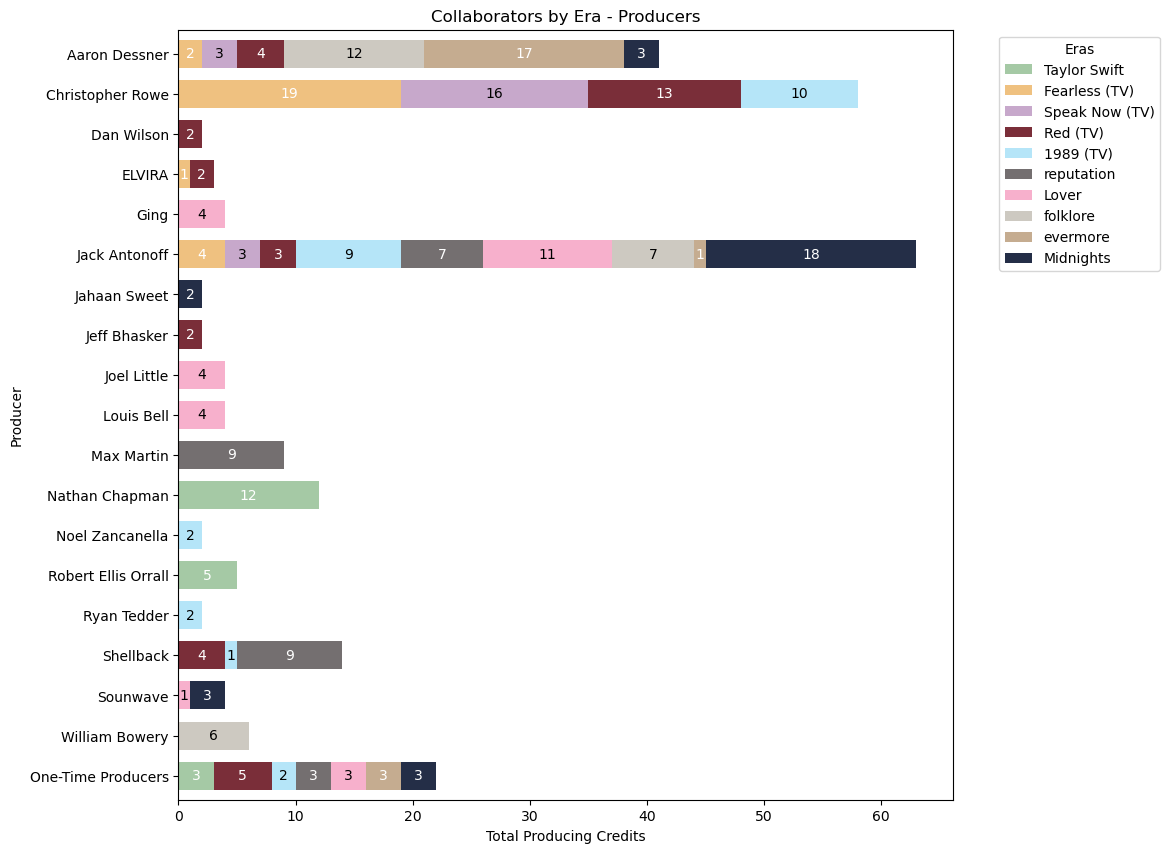

In [7]:
producers_chart = stacked_bar_chart('barh', producers, 'producer', 'song_count', 'era', eras, 'Collaborators by Era - Producers', 'Total Producing Credits', 'Producer', 'Eras')

In [9]:
test = '''
SELECT
    a.album_era,
    w.song_title,
    w.song_writer
FROM
    writers w
    LEFT JOIN songs s ON s.song_title = w.song_title
    LEFT JOIN albums a ON a.album_title = s.album_title
WHERE
    song_writer = 'Martin Johnson'

'''

pd.read_sql(test, connection)

,album_era,song_title,song_writer
0,Fearless,If This Was a Movie (Taylor's Version),Martin Johnson
1,Fearless,You’ll Always Find Your Way Back Home,Martin Johnson
2,Fearless,Two Is Better Than One,Martin Johnson


In [10]:
connection.close()